# Motivation-Breakdown

0      idel
1    cknova
2    odinfs
3      nova
4      pmfs
Name: fs, dtype: object
10


/tmp/ipykernel_397036/289275666.py:216: UserWarning: Mismatched number of handles and labels: len(handles) = 8 len(labels) = 2
  fig.legend(handles=bars, labels=legends, loc='upper center', ncol=4, bbox_to_anchor=(0.5, 1.1), frameon=False, columnspacing=0.5, handletextpad=0.2, handlelength=1, borderpad=0.2, labelspacing=0.2, fontsize=8)


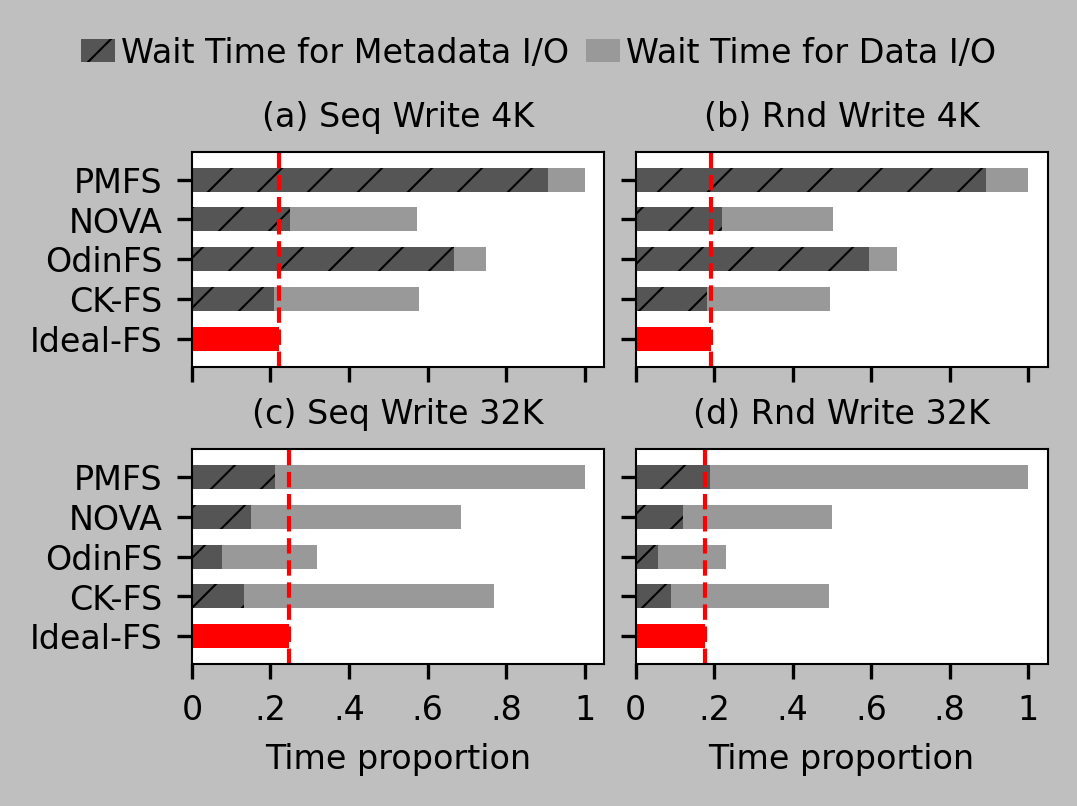

In [2]:
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import style
import pandas as pd
import numpy as np

# Paper specific settings
STANDARD_WIDTH = 17.8
SINGLE_COL_WIDTH = STANDARD_WIDTH / 2
DOUBLE_COL_WIDTH = STANDARD_WIDTH
def cm_to_inch(value):
    return value/2.54

plt.rcParams.update(plt.rcParamsDefault)
matplotlib.rcParams['text.usetex'] = False
%matplotlib inline
style.use('grayscale')
plt.rcParams["axes.grid"] = False
plt.rcParams["axes.grid.axis"] = "both"
plt.rcParams["grid.linestyle"] = ":"
plt.rcParams["grid.linewidth"] = 0.5
plt.rcParams["grid.color"] = "lightgray"
plt.rcParams['hatch.linewidth'] = 0.5
plt.rcParams["hatch.color"] = "black"
pd.options.display.max_columns = None
pd.options.display.max_rows = None
# matplotlib.rcParams['pdf.fonttype'] = 42
# matplotlib.rcParams['ps.fonttype'] = 42


# Plotting Settings
fig = plt.figure(dpi = 300, figsize = (cm_to_inch(SINGLE_COL_WIDTH), cm_to_inch(6)))
bar_width = 0.25
true_width = 0.15
inner_width = 0.1
num_job = 1

# grayscale colors
colors = ["#555555", "#999999", "#BBBBBB", "#DDDDDD", "#FFFFFF"]
patterns = ['//', '', '\\\\', "OOO", "///", "\\\\\\", "xxx"]
titles = ["(a) NOVA I/O Time and I/O Size Breakdown", "(b) PMFS I/O Time and I/O Size Breakdown"]
scales = [4, 1]
cmap="tab20"
# 文件路径和文件系统标记
files = [
    "./performance-comparison-table-pmfs",
    "./performance-comparison-table-nova",
    "./performance-comparison-table-odinfs",
    "./performance-comparison-table-cknova",
    "./performance-comparison-table-idel",
]
fss = ["pmfs", "nova", "odinfs", "cknova", "idel"]
combine_file = "./performance-comparison-table-combine"

all_data = []
for file, fs in zip(files, fss):
    df = pd.read_csv(file, sep=r"\s+", engine='python')
    df.insert(0, "fs", fs)
    all_data.append(df)

merged_df = pd.concat(all_data, ignore_index=True)

merged_df.to_csv(combine_file, index=False)

files = [combine_file]

workloads = ["write-4096", "randwrite-4096", "write-32768", "randwrite-32768"]
# workloads = ["write", "randwrite"]
workloads_remap = ["(a) Seq Write 4K", "(b) Rnd Write 4K", "(c) Seq Write 32K", "(d) Rnd Write 32K"]
# workloads_remap = ["SW", "RW"]
# workloads = ["write", "webproxy.f"]
# workloads_remap = ["SW", "WPX"]

# workloads.reverse()
# workloads_remap.reverse()

# breakdown_times = ["data_read_time(ns)", "data_write_time(ns)", "update_entry_time(ns)", "update_inode_time(ns)", "journal_time(ns)", "update_page_tail_time(ns)"]
breakdown_times = ["meta(ns)", "data(ns)"]
bars = []
global_color_idx = 0
color_map = {}
for fid, file in enumerate(files):
    # subfig = plt.subplot(1, 2, fid + 1)
    with open(file, "r") as f:
        df = pd.read_csv(f, sep=",", engine='python')
    sort_dict = {
        "pmfs": 4,
        "nova": 3,
        "odinfs": 2,
        "cknova": 1,
        "idel": 0,
    }
    # print(df.columns.tolist())
    # print(df)
    sort_df = pd.DataFrame(df['fs'].map(sort_dict))
    df = df.iloc[sort_df.sort_values(by = ["fs"]).index]
    # print(df)
    fss = df['fs'].drop_duplicates().reset_index().drop(columns=['index'])['fs']
    # fss.pop(0)
    print(fss)
    # fss = df['fs'].drop_duplicates().reset_index().drop(columns=['index'])['fs']
    # breakdown_times = ["data_write_time(ns)", "data_read_time(ns)", "update_package_time(ns)", "update_bm_time(ns)"]
    # df.columns[14:]
    # breakdown_times = breakdown_times.insert(0, "data_read_time(ns)")
    # breakdown_times = breakdown_times.insert(1, "data_write_time(ns)")
    x = list(range(1, len(workloads) + 1))
    
    # ax2 = subfig.twinx()
    pivots = []
    
    workload_map = {
        "write-4096": [],
        "randwrite-4096": [],
        "write-32768": [],
        "randwrite-32768": [],
    }

    for fs_idx, fs in enumerate(fss):
        for workload_id, workload in enumerate(workloads):
            total_time = df[(df['workloads'] == workload) & (df['fs'] == fs)]["total_time(ns)"].iloc[0]
            workload_map[workload].append(total_time)
    
    for workload_id, workload in enumerate(workloads):
        pivots = []
        for fs_idx, fs in enumerate(fss):
            subfig = plt.subplot(2, 2, workload_id + 1) 
            # global_color_idx = 0
            global_color_idx = fid * len(breakdown_times) 
            left = 0
            # for pivot in x:
            #     point = pivot - len(fss) * bar_width / 2 + bar_width / 2 + idx * bar_width
            #     points.append(point)
            # - tot / 2 + bar_width / 2 + idx * bar_width
            
            pivot = x[workload_id] - len(fss) * bar_width / 2 + bar_width / 2 + fs_idx * bar_width 
            pivots.append(pivot)
            # + bar_width / 2
            inner_left = 0
            inner_left_range = []
            start = False
            first = True
            for idx, time in enumerate(breakdown_times):
                width = df[(df['workloads'] == workload) & (df['fs'] == fs)][time].iloc[0] / max(workload_map[workload])
                if fs == "idel":
                    if first:
                        first = False
                        width = 0
                    else:
                        width = df[(df['workloads'] == workload) & (df['fs'] == fs)]["total_time(ns)"].iloc[0] / max(workload_map[workload])
                
                orig_global_color_idx = global_color_idx
                if fid == 1 and idx in [0, 1, 3, 4]:
                    global_color_idx = color_map[time]
                if fs == "idel":
                    color = "red"
                else:
                    color = colors[global_color_idx]
                bar, = subfig.barh(y=pivot, width=width, color=color, left=left, hatch=patterns[idx],linewidth=0.5, label=time, height=true_width)
                left = left + width 
                
                global_color_idx = orig_global_color_idx

                if fid == 0:
                    color_map[time] = global_color_idx
                    global_color_idx += 1
                    if workload_id == 0:
                        bars.append(bar)
                else:
                    if idx not in [0, 1, 3, 4]:
                        global_color_idx += 1
                    if workload_id == 0:
                        if idx not in [0, 1, 3, 4]:
                            bars.append(bar)
        
        idel_width = df[(df['workloads'] == workload) & (df['fs'] == "idel")]["total_time(ns)"].iloc[0] / max(workload_map[workload])
        line = plt.vlines(x=idel_width, ymin=pivots[0] - true_width / 2 - 0.1, ymax=pivots[-1] + true_width / 2 + 0.1, color="red", linewidth=1, linestyle="--")
        plt.ylim(pivots[0] - true_width / 2 - 0.1, pivots[-1] + true_width / 2+0.1)
        subfig.tick_params(bottom=False, top=False, left=False, right=False)

        # ax2.set_yticks(pivots)
        if workload_id % 2 == 0:
            _fss = fss.map({
                "idel": "Ideal-FS",
                "nova": "NOVA",
                "odinfs": "OdinFS",
                "cknova": "CK-FS",
                "pmfs": "PMFS",
            })
            yticklabels = list(_fss)
            subfig.set_yticks(pivots)
            subfig.set_yticklabels(yticklabels, fontsize=8)
        else:
            subfig.set_yticks(pivots)
            subfig.set_yticklabels([], fontsize=8)
        
        subfig.set_title(f"{workloads_remap[workload_id]}", fontsize=8)
        subfig.set_xlim([0, 1.05])
        subfig.set_xticks([0, 0.2, 0.4, 0.6, 0.8, 1])
        
        if workload_id >= 2:
            subfig.set_xticklabels(["0", ".2", ".4", ".6", ".8", "1"], fontsize=8)
            subfig.set_xlabel("Time proportion", fontsize=8)
        else:
            subfig.set_xticklabels([], fontsize=8)
            subfig.set_xlabel("", fontsize=8)
            
        ax = fig.gca()
        lw = 0.5
        for axis in ['top','bottom','left','right']:
            ax.spines[axis].set_linewidth(lw)
        subfig.tick_params(bottom=True, top=False, left=True, right=False, which='major')
print(len(bars))
legends = ["Wait Time for Metadata I/O", "Wait Time for Data I/O"]
bars = bars[2:]
# bars.append(line)
fig.legend(handles=bars, labels=legends, loc='upper center', ncol=4, bbox_to_anchor=(0.5, 1.1), frameon=False, columnspacing=0.5, handletextpad=0.2, handlelength=1, borderpad=0.2, labelspacing=0.2, fontsize=8)
plt.tight_layout(pad=0.4)
plt.savefig("./FIG-Motivation-PerfBreakDown.pdf", bbox_inches='tight', pad_inches=0)